# C3S Aerosol

This first notebook provides a practical introduction to the 
[C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=overview)
dataset.
We give a short introduction to the ECV Aerosol Properties, which contains 4 total column variables: Aerosol Optical Depth (AOD), AOD of components (Fine Mode, Dust), and aerosol single scattering albedo (SSA) as a measure of aerosol absorption; and 2 vertically resolved variables:  (dust) aerosol layer height and stratospheric aerosol extinction coefficient (vertical profiles). The algorithms and best practices for these aerosol properties have been developed within the ESA CLimate Change Initiative (CCI) and then were transferred for further extension and regular reprocessing + user support to the C3S. We start by downloading the data from the Climate Data Store (CDS) and then demonstrate three use cases for monthly mean single sensor datasets: plot a global mean map, calculate and plot a regional time series and calcculate and plot a regional multi-annual mean ("climatology") and anomaly maps and time series.

The notebook has six main sections with the following outline:


## Table of Contents

* [Introduction](#intro)
* [Download Data Using CDS API](#cdsapi)
* [Use case 1: Plot Map](#map_plot)
* [Use case 2: Regional time series](#timeseries)
* [Use case 3: "Climatology" (multi-annual mean) and Anomaly - maps and time series](#climatology)
* [References](#references)

### How to access the notebook

This tutorial is in the form of a [Jupyter notebook](https://jupyter.org/). You will not need to install any software for the training as there are a number of free cloud-based services to create, edit, run and export Jupyter notebooks such as this. Here are some suggestions (simply click on one of the links below to run the notebook):

|Binder|Kaggle|Colab|NBViewer|
|:-:|:-:|:-:|:-:|
|[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training/HEAD?urlpath=lab/tree/C3S_climate-data-store.ipynb)|[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training/blob/master/C3S_climate-data-store.ipynb)|[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-projects/copernicus-training/blob/master/C3S_climate-data-store)|[![NBViewer](https://raw.githubusercontent.com/ecmwf-projects/copernicus-training/master/img/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/ecmwf-projects/copernicus-training/blob/master/C3S_climate-data-store.ipynb)|
|(Binder may take some time to load, so please be patient!)|(will need to login/register, and switch on the internet via *settings*)|(will need to run the command `!pip install cartopy` before importing the libraries)|(this will not run the notebook, only render it)|

If you would like to run this notebook in your own environment, we suggest you install [Anaconda](https://docs.anaconda.com/anaconda/install/), which contains most of the libraries you will need. You will also need to install the CDS API (`pip install cdsapi`) for downloading data in batch mode from the CDS.

## <a id='intro'></a> Introduction


<br>
<div style="text-align: justify"> Aerosols are minor constituents of the atmosphere by mass, but critical components in terms of impact on climate. Aerosols influence the global radiation balance directly by scattering and absorbing radiation, and indirectly through influencing cloud reflectivity, cloud cover and cloud lifetime. Aerosols have a lifetime in the atmosphere of a few days upto a week so that they can be transported over thousands of kilometers. They are emitted from several different sources (e.g. natural and anthropogenic combustion processes, biogenic secondary organics, sea spray uplifting over oceans, mineral dust erosion from deserts, volcanic eruptions). Due to the inhomogenous distribution and episodic or seasonal / diurnal patterns of the various sources they exhibit large spatial and temporal variability. The different sources emmit a large range of different aerosol particles with sizes from few nanometers to many micrometers and different chemical composition. On global average aerosol have not changed over the last decades, but regionally there are significant trends and major episodes could be observed (e.g. Australian wildfires, Sahara outbreaks). </div>


<div style="text-align: justify"> The main variables provided by this dataset are meant to cover all relevant information on the global atmospheric aerosol distribution: aerosol optical depth (total abundance), fine mode aerosol optical depth (particles with diameter smaller than 1 micron), dust aerosol optical depth (mineral dust), single scattering albedo (ranging from 0 = fully absorbing to 1 = non-absorbing), (dust) aerosol layer height and stratospheric aerosol extinction coefficient (vertical profiles). These variables are derived from observations from several satellite sensors using a set of different processing techniques. This provides the possibility to derive a large set of complementary aerosol properties needed to describe the complex nature of atmospheric aerosols. Furthermore, different algorithms have their specific strengths and weaknesses, meaning that datasets originating from the same sensor but processed by different algorithms provide a way to evaluate uncertainties (e.g. areas of good or bad agreement between them). Altogether, the aerosol properties dataset is very extensive and offers a choice of complementary options – which is appropriate depends on the intended application. </div>

Please find further information about the dataset as well as the data in the Climate Data Store catalogue entry Aerosol properties, sections "Overview", "Download data" and "Documentation": 
- [C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=overview)

#### Import libraries

We will be working with data in NetCDF format. To best handle this data we will use the netCDF4 python library. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy.

We are using `cdsapi` to download the data. This package is not yet included by default on most cloud platforms. You can use `pip` to install it: <br>


In [1]:
#!pip install cdsapi

In [2]:
%matplotlib inline

# CDS API library
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import numpy.ma as ma
import netCDF4 as nc

# Library to work with zip-archives, OS-functions and pattern expansion
import zipfile
import os
from pathlib import Path

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import matplotlib as mplt
import matplotlib.dates as md
import cartopy.crs as ccrs

# Libraries for style parameters
from pylab import rcParams

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

In [ ]:
# The following style parameters will be used for all plots in this use case.
mplt.style.use('seaborn')
rcParams['figure.figsize'] = [15, 5]
rcParams['figure.dpi'] = 350
rcParams['font.family'] =  'serif'
rcParams['font.serif']  =  mplt.rcParamsDefault['font.serif']
rcParams['mathtext.default'] = 'regular'
rcParams['mathtext.rm'] = 'serif:light'
rcParams['mathtext.it'] = 'serif:italic'
rcParams['mathtext.bf'] = 'serif:bold'
plt.rc('font', size=17)          # controls default text sizes
plt.rc('axes', titlesize=17)     # fontsize of the axes title
plt.rc('axes', labelsize=17)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

projection=ccrs.PlateCarree()
mplt.rc('xtick', labelsize=9) 
mplt.rc('ytick', labelsize=9)

## <a id='cdsapi'></a> Download data using CDS API

#### Set up CDS API credentials

<div style="text-align: justify"> We will request data from the Climate Data Store (CDS): https://cds.climate.copernicus.eu/cdsapp#!/home. In case you don't have an account yet, please click on "Login/register" at the right top and select "Create new account". With the process finished you are able to login to the CDS and can search for your preferred data.</div>

We will request data from the CDS in batch mode with the help of the CDS API. 
First, we need to manually set the CDS API credentials. 
To do so, we need to define two variables: URL and KEY. 
To obtain these, first login to the CDS, then visit https://cds.climate.copernicus.eu/api-how-to and copy the string of characters listed after "key:". Replace the `#########` below with this string.


In [3]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

Next, we specify a data directory in which we will download our data and all output files that we will generate:

In [4]:
DATADIR='./data_dir/'
PLOTDIR=DATADIR + 'plots/'
for _dir in [DATADIR, PLOTDIR]:
    if not os.path.exists(PLOTDIR):
        os.mkdir(PLOTDIR)

#### Search for data

To search for data, visit the CDS website: https://cds.climate.copernicus.eu/cdsapp#!/home.
Here you can search for aerosol data using the search bar. The data we need for this use case is the [C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=overview).
The Aerosol properties comprise several total column aerosol variables: (total) AOD, Fine-Mode AOD, Dust AOD, Single Scattering Albedo and further vertically resolved aerosol variables: stratospheric extinction profiles, aerosol layer height. Most catalogue entries comprise data from a number of sensors and algorithms.

Having selected the correct catalogue entry, we now need to specify the time aggregation, variable, sensor, algorithm, and temporal coverage we are interested in; the datasets are all global. 
These can all be selected in the **"Download data"** tab. In this tab a form appears  which guides the user to select existing combinations of the following parameters to download:

- Time aggregation: `Monthly`
- Variable: `Dust Aerosol Optical Depth`
- Sensor on satellite: `IASI on METOP-C`
- Algorithm: `MAPIR`
- Year: (use "Select all" button)
- Month: (use "Select all" button)
- Version: (choose the latest version / highest number for this sensor / algorithm) 
- Format: `Compressed zip file (.zip)`
- Orbit: `Descending` (for IASI only)

If you have not already done so, you will need to accept the **terms & conditions** of the data before you can download it.

At the end of the download form, select **`Show API request`**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below) ...

Depending on the lenght of the record chosen and the internet traffic the download may take one to several minutes.

To illustrate the variability we include 3 examples below (2 as comment lines only).

In [5]:
c = cdsapi.Client()  #url=URL, key=KEY)

c.retrieve(
    'satellite-aerosol-properties',
    {
        'format': 'zip',
            'month': ['01', '02', '03','04', '05', '06','07', '08', '09','10', '11', '12',],

        #0 SLSTR on Sentinel-3A: Swansea algorithm, Fine Mode AOD
        #0 'time_aggregation': 'monthly_average',
        #0 'variable': 'fine_mode_aerosol_optical_depth',
        #0 'sensor_on_satellite': 'slstr_on_sentinel_3a',
        #0 'algorithm': 'swansea',
        #0 'year': ['2017', '2018', '2019','2020', '2021', '2022',],
        #0 'version': 'v1.12',
    
        #1 IASI on METOP-C: ULB algorithm, Dust AOD
        'time_aggregation': 'monthly_average',
        'variable': 'dust_aerosol_optical_depth',
        'sensor_on_satellite': 'iasi_on_metopc',
        'algorithm': 'ulb',
        'year': ['2019', '2020', '2021','2022',],
        'version': 'v9',
        'orbit': 'descending',

        #2 POLDER on PARASOL: GRASP algorithm, single scattering albedo
        #2 'time_aggregation': 'monthly_average',
        #2 'variable': 'single_scattering_albedo',
        #2 'sensor_on_satellite': 'polder_on_parasol',
        #2 'algorithm': 'grasp',
        #2 'year': ['2005', '2006', '2007','2008', '2009', '2010','2011', '2012', '2013',],
        #2 'version': 'v2.10',

        #3 IASI on METOP-C: LMD algorithm, dust layer height
        #3 'time_aggregation': 'monthly_average',
        #3 'variable': 'dust_aerosol_layer_height',
        #3 'sensor_on_satellite': 'iasi_on_metopc',
        #3 'algorithm': 'lmd',
        #3 'year': ['2019', '2020', '2021','2022',],
        #3 'version': 'v2.2',
        #3 'orbit': 'descending',
        
        #4 GOMOS on ENVISAT: AERGOM algorithm, aerosol extinction profiles
        #4 'time_aggregation': '5_daily_composite',
        #4 'variable': 'aerosol_extinction_coefficient',
        #4 'sensor_on_satellite': 'gomos_on_envisat',
        #4 'algorithm': 'aergom',
        #4 'year': ['2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',],
        #4 'version': 'v4.00',
        #4 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09','10', '11', '12',
        #4         '13', '14', '15', '16', '17', '18', '19', '20', '21','22', '23', '24',
        #4         '25', '26', '27', '28', '29', '30', '31',],
    },
    f'{DATADIR}/download.zip')

2023-10-23 17:02:01,824 INFO Welcome to the CDS
2023-10-23 17:02:01,825 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-aerosol-properties
2023-10-23 17:02:01,996 INFO Request is completed
2023-10-23 17:02:01,997 INFO Downloading https://download-0004-clone.copernicus-climate.eu/cache-compute-0004/cache/data9/dataset-satellite-aerosol-properties-b9a80ae7-7586-4080-9fad-b87d443c2e1d.zip to ./data_dir//download.zip (39.4M)
2023-10-23 17:02:14,133 INFO Download rate 3.2M/s   


Result(content_length=41326484,content_type=application/zip,location=https://download-0004-clone.copernicus-climate.eu/cache-compute-0004/cache/data9/dataset-satellite-aerosol-properties-b9a80ae7-7586-4080-9fad-b87d443c2e1d.zip)

Please define your dataset characteristics (copy from above as used in the CDS Download page).

IMPORTANT NOTE: If you have once donwloaded a specific dataset and want to re-use it, you can re-start from here using this dataset. Then you need to skip the code block "Unpack the data".

In [6]:
#0 SLSTR on Sentinel-3A: Swansea algorithm, Fine Mode AOD
#0 algorithm = "swansea"
#0 sensor_on_satellite = "slstr_on_sentinel_3a"
#0 variable = 'fine_mode_aerosol_optical_depth'
#0 years = ['%04d'%(yea) for yea in range(2017, 2023)]

#1 IASI on METOP-C: ULB algorithm, Dust AOD
algorithm = "ulb"
sensor_on_satellite = "iasi_on_metopc"
variable = 'dust_aerosol_optical_depth'
years = ['%04d'%(yea) for yea in range(2019, 2023)]

#2 POLDER on PARASOL: GRASP algorithm, single scattering albedo
#2 algorithm = "grasp"
#2 sensor_on_satellite = "polder_on_parasol"
#2 variable = 'single_scattering_albedo'
#2 years = ['%04d'%(yea) for yea in range(2005, 2013)]

#3 IASI on METOP-C: ULB algorithm, Dust ALH
#3 algorithm = "lmd"
#3 sensor_on_satellite = "iasi_on_metopc"
#3 variable = 'dust_aerosol_layer_height'
#3 years = ['%04d'%(yea) for yea in range(2019, 2023)]

#4 GOMOS on ENVISAT: AERGOM algorithm, aerosol extinction profiles
#4 algorithm = "aergom"
#4 sensor_on_satellite = "gomos_on_envisat"
#4 variable = 'aerosol_extinction_coefficient'
#4 years = ['%04d'%(yea) for yea in range(2002, 2012)]

Correction of variable names: There are a few variable naming inconsistencies which we automtically adjusted by the following code block.

In [7]:
if variable == 'aerosol_optical_depth':
    if algorithm == 'ens':
        variable = 'AOD550'
    else:
        variable = 'AOD550_mean'
elif variable == 'fine_mode_aerosol_optical_depth':
    if algorithm == 'ens':
        variable = 'FM_AOD550'
    else:
        variable = 'FM_AOD550_mean'
elif variable == 'dust_aerosol_optical_depth':
    if algorithm == 'ens':
        variable = 'DAOD550'
    elif algorithm == 'lmd':
        variable = 'Daod550'
    elif algorithm == 'imars':
        variable = 'D_AOD550'
    else:
        variable = 'D_AOD550_mean'
elif variable == 'single_scattering_albedo':
    variable = 'SSA443'
elif variable == 'dust_aerosol_layer_height':
    if algorithm == 'lmd':
        variable = 'Mean_dust_layer_altitude'
    if algorithm == 'mapir':
        variable = 'D_ALT_mean'
elif variable == 'aerosol_extinction_coefficient':
    variable = 'AEX550'

#### Unpack the data

The zip-files have now been requested and downloaded to the data directory that we have specified earlier.
For the purposes of our use cases, we will unzip the archive and store all netCDF files in a specific directory for this algorithm.
There you can also search and open individual files with any tool suitable for reading netCDF format, e.g. Panoply.

IMPORTANT NOTE: If you had already downloaded and unzpped the record you intend to visualize now, then you need to skip this block. (To check you need to confirm that the directory timeseries_<algorithm>1 exists and contains all the monthly data you intend to use).
    

In [8]:
with zipfile.ZipFile(f'{DATADIR}download.zip', 'r') as zip_ref:
    zip_ref.extractall(f'{DATADIR}timeseries_{algorithm}1')
dir = f'{DATADIR}timeseries_{algorithm}1/'
files = os.listdir(dir)

One IASI algorithm (MAPIR) provides less than global coverage; in this case we make the datasets global (filling the empty parts with NaN values) for consistent technical treatment in the use cases.

In [9]:
if algorithm == 'mapir':
    for file in files:
        path = dir + file
        datas = nc.Dataset(path,'r')
        lat = datas.variables['latitude'][:]
        lon = datas.variables['longitude'][:] 
        min_lat, max_lat = np.nanmin(lat), np.nanmax(lat)
        min_lon, max_lon = np.nanmin(lon), np.nanmax(lon)
        lon_n = np.linspace(-179.5, stop = 179.5, num = 360)
        lat_n = np.linspace(-89.5, 89.5, num = 180)
        index_max_lat = np.where(lat_n == max_lat)
        index_min_lat = np.where(lat_n == min_lat)
        index_max_lon = np.where(lon_n == max_lon)
        index_min_lon = np.where(lon_n == min_lon)
        data = np.full((len(lat_n),len(lon_n)), np.nan)
        data[index_min_lat[0][0] : index_max_lat[0][0]+1, index_min_lon[0][0] : index_max_lon[0][0]+1] = datas[variable][ : , : ]
        data = ma.masked_where(data<=-900, data)

    # create global NetCDF4 File 
        fpath= f'{dir}' + file[:-3] + '_global.nc' # definition of new filename
        with nc.Dataset(fpath, "w", format="NETCDF4") as climatology:
            climatology.createDimension("longitude",size=(len(lon_n)))
            climatology.createDimension("latitude",size=(len(lat_n)))
            climatology.createVariable("longitude", "float32", dimensions=("longitude"))
            climatology.variables["longitude"].units = "deg"
            climatology.variables["longitude"][:] = lon_n
            climatology.createVariable("latitude", "float32", dimensions=("latitude"))
            climatology.variables["latitude"].units = "deg"
            climatology.variables["latitude"][:] = lat_n
            
            climatology.createVariable(variable, "float32", dimensions=("latitude", "longitude"))
            climatology.variables[variable][:] = data
            climatology.variables[variable].units = ""
        os.remove(f'{dir}' + file)

# <a id='map_plot'></a> Use case 1: Plot map


Firstly, we should get an overview of the parameter by plotting the time averaged monthly global distribution. 
The data are stored in NetCDF format, and we will use NetCDF4 Python library to work with the data. 
We will then use Matplotlib and Catropy to visualise the data.

Select the dataset by copying one filename from the specific directory for this algorithm (which is automatically tranferred from the unpacking code block above).
The dataset is then read into the Jupyter notebook and the map plot is created, displayed and stored into your main directory.

In [10]:
dir = f'{DATADIR}timeseries_{algorithm}1/'

#0 filename = '202106-C3S-L3_AEROSOL-AER_PRODUCTS-SLSTR-SENTINEL3A-SWANSEA-MONTHLY-v1.12.nc'
filename = '202106-C3S-L3_AEROSOL-AER_PRODUCTS-IASI-METOPC-ULB-MONTHLY-v9DN.nc'
#2 filename = '201106-C3S-L3_AEROSOL-AER_PRODUCTS-POLDER-PARASOL-GRASP-MONTHLY-v2.10.nc'
#3 filename = '202106-C3S-L3_AEROSOL-AER_PRODUCTS-IASI-METOPC-LMD-MONTHLY-v2.2DN.nc'
#4 filename = '20070604-C3S-L3_AEROSOL-AER_PRODUCTS-GOMOS-ENVISAT-AERGOM-5DAILY-v4.00.nc'

# one algorithm (mapir) needs a specific filename:
# filename = '202106-C3S-L3_AEROSOL-AER_PRODUCTS-IASI-METOPC-MAPIR-MONTHLY-v4.1DN_global.nc'

path = dir + filename

In [11]:
# set altitude layer for vertical extinction profile
altitude_layer = 10 # layer number

datas = nc.Dataset(path,'r')
if algorithm == 'lmd':
    lat = datas.variables['Latitude'][:]
    lon = datas.variables['Longitude'][:] 
else:
    lat = datas.variables['latitude'][:]
    lon = datas.variables['longitude'][:]     
if algorithm != 'aergom':
    data = datas.variables[variable][:,:]
else:
    data = datas.variables[variable][altitude_layer,:,:]
if algorithm == 'imars':
    data = np.transpose(data)
if algorithm == 'aergom':
    alt = datas.variables['altitude'][:]
datas.close()


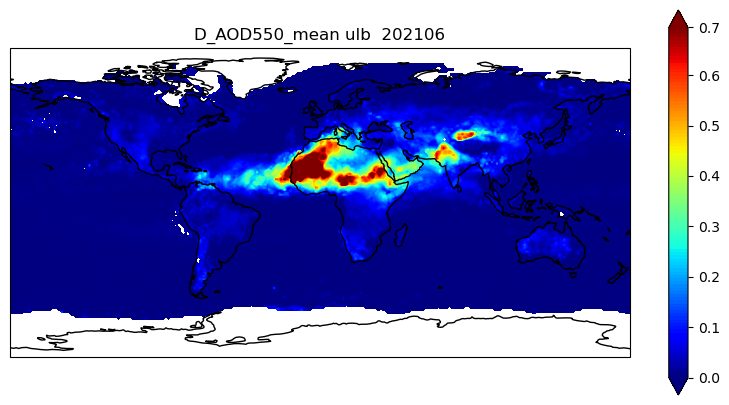

In [14]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1, projection=projection)
ax.coastlines(color='black')

if variable[0:1] == 'S': # single scattering albedo
    levels = np.linspace(0.701, 1.001, 110, endpoint = False ) 
elif variable[5:9] == 'dust' or variable[2:5] == 'ALT': # dust layer altitude
     levels = np.linspace(0, 6.001, 110, endpoint = False ) 
# AOD, FM-AOD, DAOD:
elif variable[0:3] == 'AOD' or variable[0:2] == 'FM' or variable[0:2] == 'DA' or variable[0:2] == 'Da' or variable[0:5] == 'D_AOD':
    levels = np.linspace(0, 0.701, 110, endpoint = False ) 
elif variable[0:3] == 'AEX':
    levels = np.linspace(0, 0.0021, 110, endpoint = False )

pc = ax.contourf(lon, lat, data, levels=levels,  transform=projection, cmap='jet', extend='both')
#ax.set_extent([0, 30, 40, 60]) # region (lon_min, lon_max, lat_min, lat_mx) in map

if variable[0:1] == 'S': # single scattering albedo
    fig.colorbar(pc,ticks=[0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]) 
elif variable[5:9] == 'dust' or variable[2:5] == 'ALT': # dust layer altitude
    fig.colorbar(pc,ticks=[0.0,1.0,2.0,3.0,4.0,5.0,6.0]) 
# AOD, FM-AOD, DAOD:
elif variable[0:3] == 'AOD' or variable[0:2] == 'FM' or variable[0:2] == 'DA' or variable[0:2] == 'Da' or variable[0:5] == 'D_AOD':
    fig.colorbar(pc,ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]) 
elif variable[0:3] == 'AEX':
    fig.colorbar(pc,ticks=[0.0, 0.0005, 0.001, 0.0015, 0.002])     

title = variable + ' ' + algorithm + ' ' +  ' ' + filename[0:6]
if algorithm == 'aergom':
    title = title + filename[6:8] + ' ' + str(altitude_layer + 7) + 'km'
ax.set_title(title, fontsize=12)
if algorithm != 'aergom':
    fig.savefig(PLOTDIR + 'map_' + variable + '_' + algorithm + '_' + filename[0:6] + '.png', dpi=500, bbox_inches='tight')
else:
    fig.savefig(PLOTDIR + 'map_' + variable + '_' + algorithm + '_' + filename[0:8] + '.png', dpi=500, bbox_inches='tight')

**FIGURE 1:** You can see here a typical global aerosol map with well-known features (depending on season and variable) such as the spring Sahara dust outflow over the Atlantic (Dust AOD), the autumn biomass burning in Southern Africa and the Amazonas (Fine Mode AOD), and several more.

# <a id='timeseries'></a> Use case 2: Regional time series

After looking at one example of a monthly time averagged global distribution, in the next step we further investigate the dataset. The single sensor aerosol datasets are upto 15 years long, so that another useful way of visualizing is a time series. We will calculate a regional time series, plot it, and discuss its features.

Here is a common definition for a set of areas with rather homogeneous aerosol properties and meaningful aerosol behaviour. Own regions can be easily defined the same way. 

In [15]:
extent = { # 'Region' : [lon_min, lon_max, lat_min, lat_max],
            'Europe': [-15, 50, 36, 60],
            'Boreal': [-180, 180, 60, 85],
            'Asia_North': [50, 165, 40, 60],
            'Asia_East': [100, 130, 5, 41],
            'Asia_West': [50, 100, 5, 41],
            'China_South-East': [103, 135, 20, 41],
            'Australia': [100, 155, -45, -10],
            'Africa_North': [-17, 50, 12, 36], 
            'Africa_South': [-17, 50, -35, -12],
            'South_America': [-82, -35, -55, 5],
            'North_America_West': [-135, -100, 13, 60],
            'North_America_East': [-100, -55, 13, 60],
            'Indonesia': [90, 165, -10, 5],
            'Atlanti_Ocean_dust': [-47, -17, 5, 30],
            'Atlantic_Ocean_biomass_burnig': [-17, 9, -30, 5],
            'World': [-180, 180, -90, 90],
            'Asia': [50, 165, 5, 60],
            'North_America': [-135, -55, 13, 60], 
            'dust_belt': [-80, 120, 0, 40], 
            'India': [70, 90, 8, 32], 
            'Northern_Hemisphere': [-180, 180, 0, 90], 
            'Southern_Hemisphere': [-180, 180, -90, 0],
            }

We now choose one region and set the minimum required coverage (fraction of years with valid data in a month) for the timeseries. 

In [16]:
#0 region = 'Europe'
region = 'dust_belt'
#2 region = 'Africa_South'
#3 region = 'dust_belt'
#4 region = 'Southern_Hemisphere'

min_coverage = 0.5

if algorithm == 'aergom':
    min_coverage = 0.05

Next, we calculate the cell indices for this region from the region coordinates.

In [17]:
area_coor = extent[region]
lon1 = 180 + area_coor[0]
lon2 = 180 + area_coor[1]
lat1 = 90 + area_coor[2]
lat2 = 90 + area_coor[3]

pixel_min = min_coverage*(lon2-lon1)*(lat2-lat1)

if algorithm == 'aergom':
    pixel_min = pixel_min / 300 # as this product has pixels of 5 x 60 degree lat/lon

Then, we select the data, calculate the mean over the region and make time series lists.

In [18]:
valid_count = 0

months = ['%02d'%(mnth) for mnth in range(1,13)]
days = ['%02d'%(day) for day in range(1,32)]
days28 = ['%02d'%(day) for day in range(1,29)]
days30 = ['%02d'%(day) for day in range(1,31)]
time = []
var = []
files = os.listdir(dir)

if algorithm != 'aergom': 
    for year in years:
        for month in months:
            t = str(year) + str(month)
            time_element = md.datestr2num(str(year) + '-' + str(month))
            for file in files:
                if t in file:
                    path = dir + file
                    datas = nc.Dataset(path,'r')
                    if algorithm == 'imars':
                        sel = datas[variable][lon1 : lon2, lat1 : lat2]
                    else:
                        sel = datas[variable][lat1 : lat2, lon1 : lon2]
                    var_count = np.ma.count(sel)
                    condition_pixel = np.where(var_count>=pixel_min, 1, np.nan)
                    var_mean = np.ma.mean(sel)
                    var_data = var_mean * condition_pixel
                    if var_count >= pixel_min:
                            valid_count=valid_count+1
                    var.append(var_data)
                    time.append(time_element)
                    datas.close()
            if time_element not in time:
                var.append(np.nan)
                time.append(time_element)
else:
    for year in years:
        for month in months:
            daysx=days
            if month == '02':
                daysx=days28
            if month == '04' or month == '06' or month == '09' or month == '11':
                daysx=days30
            for day in daysx:
                t = str(year) + str(month) + str(day)
                time_element = md.datestr2num(str(year) + '-' + str(month) + '-' + str(day))
                for file in files:
                    if t in file:
                        path = dir + file
                        datas = nc.Dataset(path,'r')
                        sel = datas[variable][altitude_layer,lat1 : lat2, lon1 : lon2]
                        var_count = np.ma.count(sel)
                        condition_pixel = np.where(var_count>=pixel_min, 1, np.nan)
                        var_mean = np.ma.mean(sel)
                        var_data = var_mean * condition_pixel
                        if var_count >= pixel_min:
                            valid_count=valid_count+1
                        var.append(var_data)
                        time.append(time_element)
                        datas.close()
print(valid_count)

40


And finally, we plot the time series.

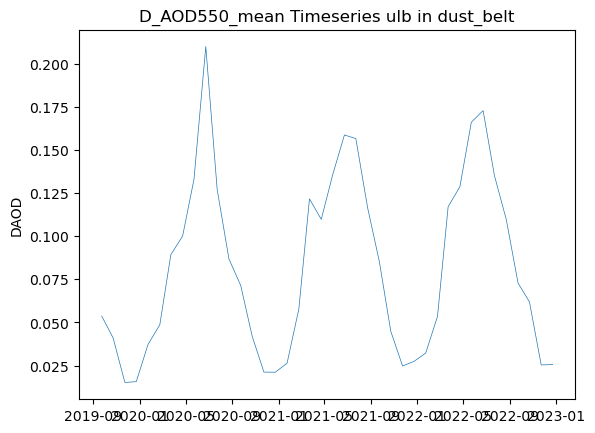

In [19]:
plt.plot_date(time, var, '-', label = variable, linewidth = 0.5)
if variable[0:3] == 'AOD': # Total AOD
    plt.ylabel("AOD")
if variable[0:2] == 'DA' or variable[0:2] == 'Da' or variable[0:5] == 'D_AOD': # Dust AOD
    plt.ylabel("DAOD")
if variable[0:2] == 'FM': # Fine Mode AOD
        plt.ylabel("FM_AOD")
if variable[0:1] == 'S': # single scattering albedo
        plt.ylabel("SSA")
if variable[5:9] == 'dust' or variable[2:5] == 'ALT': # Dust Altitude
        plt.ylabel("DALH [km]")
if variable[0:3] == 'AEX':
        plt.ylabel("AEX [km -1]")
      
plt.title(variable + ' Timeseries ' + algorithm + ' in ' + region)
plt.savefig(PLOTDIR + 'timeseries_' + variable + '_' + algorithm + '_' + region + '.png', dpi=500, bbox_inches='tight')

# print(var)

**FIGURE 2:** Such an aerosol time series typically shows a more or less obvious annual cycle related to the annual cycle of the relevant sources and meteorological conditions. In some years and regions exceptional peaks may be seen.

# <a id='climatology'></a> Use case 3: "Climatology" (multi-annual mean) and anomaly - maps and time series

In the next step we further investigate the dataset by comparing the data of individual months to a longer-term mean state (multi-annual mean or "climatology" if of sufficient length).

We define the sub directory in which the climatology data will be stored.

Note that the following code blocks are not yet prepared for the stratospheric aerosol extinction profiles.

In [ ]:
if not os.path.exists(dir + '/climatology'):
    os.makedirs(dir + '/climatology')
dir_clima = dir + '/climatology/'

We set the minimum required number of years with valid data.

In [ ]:

min_years = len(years) * min_coverage
print(min_years)


2.0


Then, we calculate the mean of all years per calendar month and the standard deviation for each lat-lon cell, where the required minimum of years has valid data and store them in one NetCDF4 file per calendar month. 

In [ ]:
for month in months:
    aod = []
    for year in years:
        t = str(year) + str(month)
        for file in files:
            if t in file:
                titel = file
                path = dir + titel
                datas = nc.Dataset(path,'r')
                sel = datas[variable][ : , : ]
                if algorithm == 'imars':
                    sel = np.transpose(sel)
                aod.append(sel)
    count_AOD = np.ma.count(aod, axis=0)
    condition_years = np.where(count_AOD>=min_years, 1, np.nan)
    AOD_mean = np.ma.mean(aod, axis = 0)
    AOD = AOD_mean * condition_years
    AOD_sdev = np.ma.std(aod, axis = 0)

#create NetCDF4 File with climatology and standard derivation

    fpath= f'{dir_clima}/climatology_' + month + '.nc' # definition of new filename

    with nc.Dataset(fpath, "w", format="NETCDF4") as climatology:
        lon = np.linspace(-179.5, stop = 179.5, num = 360)
        lat = np.linspace(-90, 90, num = 180)
        climatology.createDimension("Longitude",size=(len(lon)))
        climatology.createDimension("Latitude",size=(len(lat)))
        climatology.createVariable("Longitude", "float32", dimensions=("Longitude"))
        climatology.variables["Longitude"].units = "deg"
        climatology.variables["Longitude"][:] = lon
        climatology.createVariable("Latitude", "float32", dimensions=("Latitude"))
        climatology.variables["Latitude"].units = "deg"
        climatology.variables["Latitude"][:] = lat
        
        climatology.createVariable(variable, "float32", dimensions=("Latitude", "Longitude"))
        climatology.variables[variable][:] = AOD
        climatology.variables[variable].units = ""
        climatology.createVariable(variable + '_sdev', "float32", dimensions=("Latitude", "Longitude"))
        climatology.variables[variable + '_sdev'][:] = AOD_sdev
        climatology.variables[variable + '_sdev'].units = ""

NameError: name 'months' is not defined

## <a id='climatology_map'></a> Open NetCDF4 File and plot climatology map for selected calendar month

We select one calendar month, read its netCDF file and prepare the monthly multi-annual mean map.

In [ ]:

month = '06'

path = f'{dir_clima}climatology_' + month + '.nc'

datas = nc.Dataset(path,'r')
lat = datas.variables['Latitude'][:]
lon = datas.variables['Longitude'][:] 
data = datas.variables[variable][:,:]
datas.close()

fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(1,1,1,projection=projection)
ax.coastlines(color='black')

if variable[0:1] == 'S': # single scattering albedo
    levels = np.linspace(0.701, 1.001, 110, endpoint = False ) 
elif variable[5:9] == 'dust' or variable[2:5] == 'ALT': # dust layer altitude
     levels = np.linspace(0, 6.001, 110, endpoint = False ) 
# AOD, FM-AOD, DAOD:
elif variable[0:3] == 'AOD' or variable[0:2] == 'FM' or variable[0:2] == 'DA' or variable[0:2] == 'Da' or variable[0:5] == 'D_AOD':
    levels = np.linspace(0, 0.701, 110, endpoint = False ) 

pc = ax.contourf(lon, lat, data, levels=levels,  transform=projection, cmap='jet', extend='both')
#ax.set_extent([0, 30, 40, 60]) # region (lon_min, lon_max, lat_min, lat_mx) in map

if variable[0:1] == 'S': # single scattering albedo
    fig.colorbar(pc,ticks=[0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]) 
elif variable[5:9] == 'dust' or variable[2:5] == 'ALT': # dust layer altitude
    fig.colorbar(pc,ticks=[0.0,1.0,2.0,3.0,4.0,5.0,6.0]) 
# AOD, FM-AOD, DAOD:
elif variable[0:3] == 'AOD' or variable[0:2] == 'FM' or variable[0:2] == 'DA' or variable[0:2] == 'Da' or variable[0:5] == 'D_AOD':
    fig.colorbar(pc,ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]) 

title = variable + ' climatology ' + algorithm + ' ' + month
ax.set_title(title,fontsize=12)
fig.savefig(PLOTDIR + 'map_climatology_' + variable + '_' + algorithm + '_' + month + '.png', dpi=500, bbox_inches='tight')

NameError: name 'dir_clima' is not defined

**FIGURE 3:** This figure shows (similar to the example monthly mean map above) those typical aerosol features which occur in the selected calendar month, but now averaged over several years and thus showing a multi-annual mean state of the atmosphere in that calendar month.

## Regional climatology: calculate and plot as time series


For the region and variable as selected above and the full timerange used for the multi-annual mean, we calculate now regional averages of the climatology in each calendar month and of each invidual month in the time series. We also calculate the standard deviation for each calendar month as measure of the multi-annual variability.

In [ ]:
files_clima = os.listdir(dir_clima)

year = []
climatology = []
sdev = []

for month in months:
    t = str(month)
    for file in files_clima:
        if t in file:
            titel = file
            path = dir_clima + titel
            datas = nc.Dataset(path,'r')
            climatology_sel = datas[variable][lat1 : lat2 , lon1 : lon2]
            climatology_mean = np.nanmean(climatology_sel)
            climatology.append(climatology_mean)
            sdev_sel = datas[variable + '_sdev'][lat1 : lat2 , lon1 : lon2]
            sdev_mean = np.nanmean(sdev_sel)
            sdev.append(sdev_mean)
            year.append(int(month))
            datas.close()

### Plot "climatology" and its standard deviation

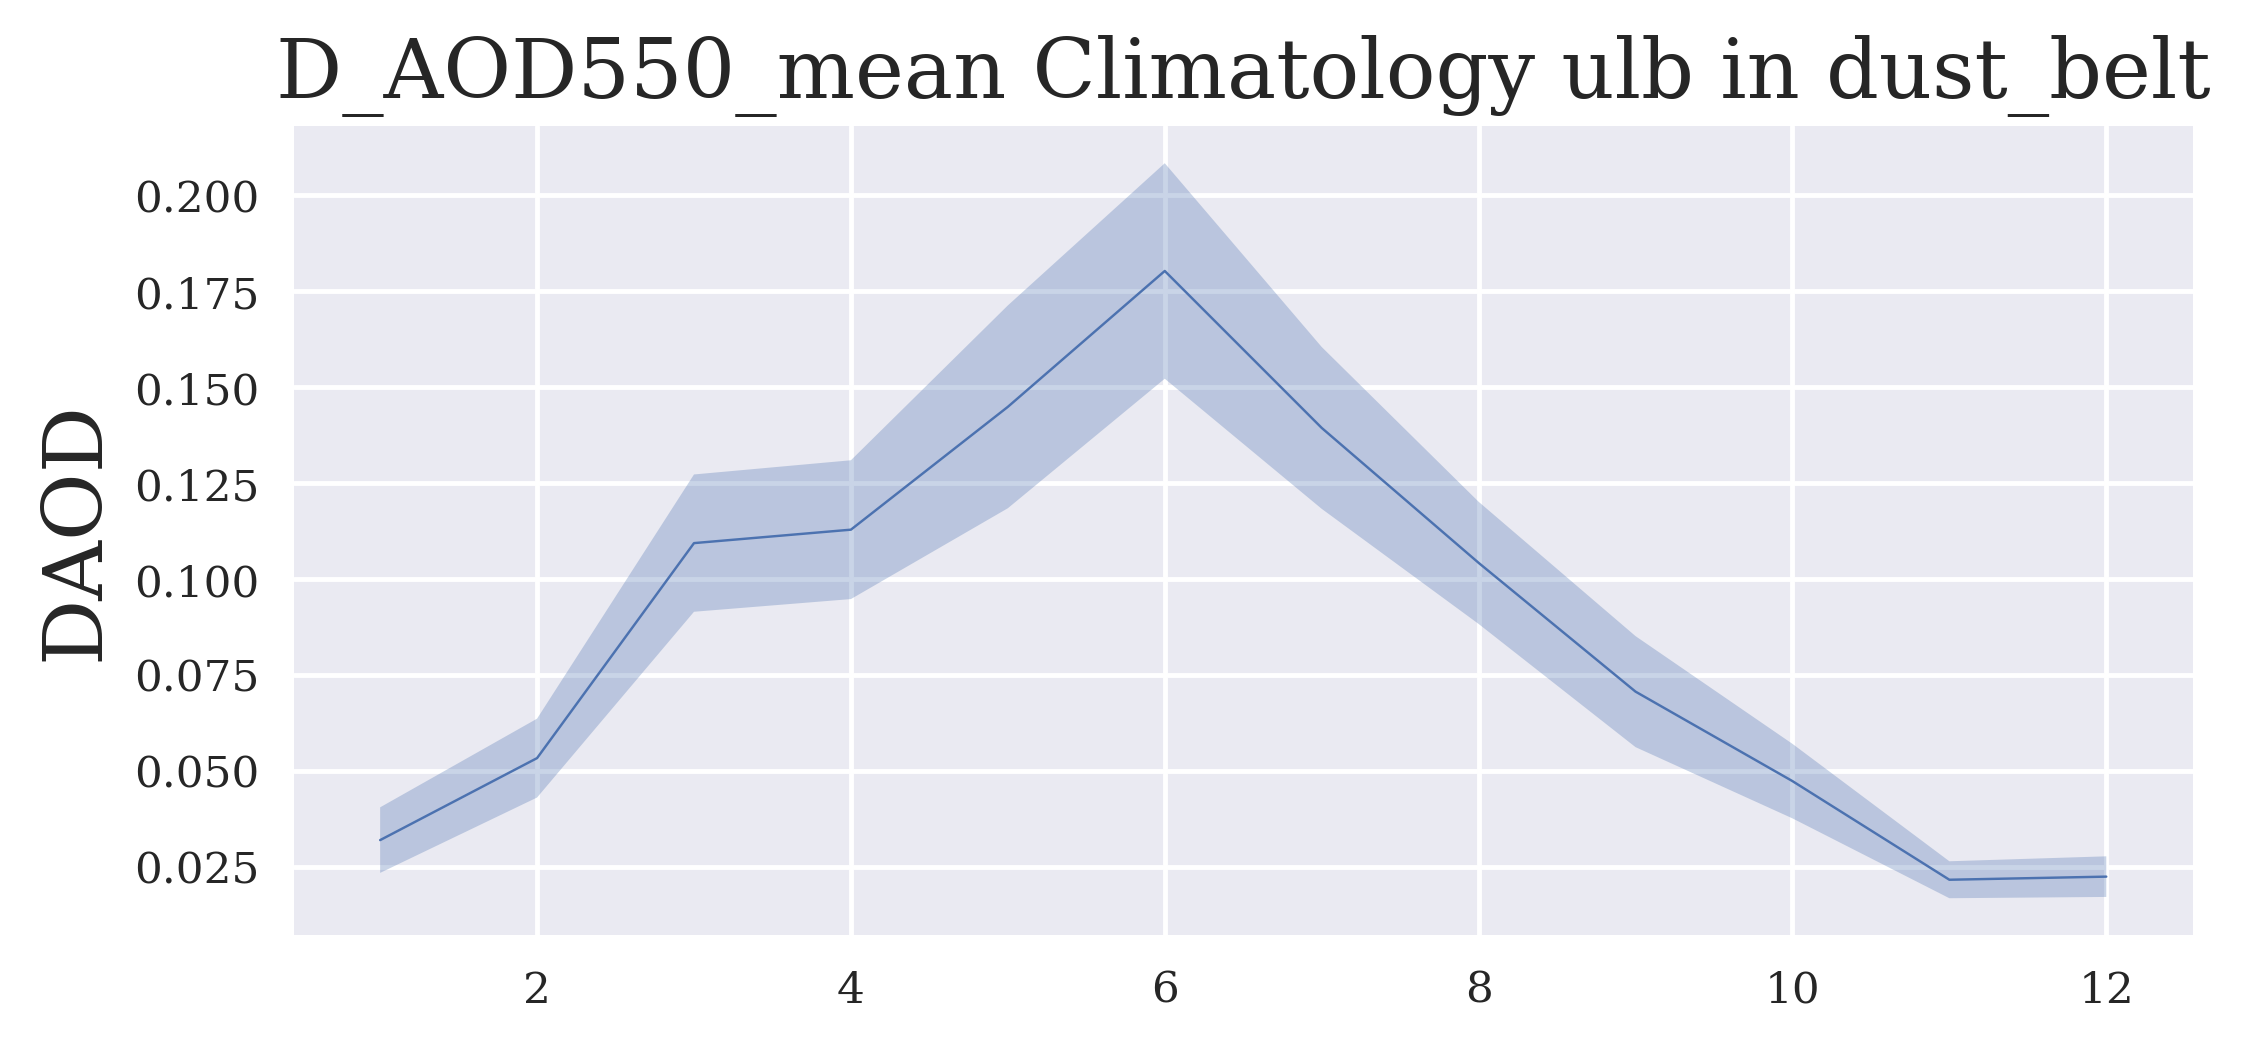

In [ ]:
sdev_p = [climatology[i] + 0.5*sdev[i] for i in range(len(climatology))] 
sdev_m = [climatology[i] - 0.5*sdev[i] for i in range(len(climatology))]

fig = plt.figure(figsize=(7,3))
plt.fill_between(year, sdev_p, sdev_m, alpha = 0.3)
plt.plot(year, climatology, '-', label = variable, linewidth = 0.5)

if variable[0:3] == 'AOD': # Total AOD
    plt.ylabel("AOD")
if variable[0:2] == 'DA' or variable[0:2] == 'Da' or variable[0:5] == 'D_AOD': # Dust AOD
    plt.ylabel("DAOD")
if variable[0:2] == 'FM': # Fine Mode AOD
        plt.ylabel("FM_AOD")
if variable[0:1] == 'S': # single scattering albedo
        plt.ylabel("SSA")
if variable[5:9] == 'dust' or variable[2:5] == 'ALT': # Dust Altitude
        plt.ylabel("DALH")
                
plt.title(variable + ' Climatology ' + algorithm + ' in ' + region)
plt.savefig(PLOTDIR + 'annual_climatology_' + variable + '_' + algorithm + '_' + region +'.png', dpi=500, bbox_inches='tight')

**FIGURE 4:** The figure shows now the average annual cycle in the selected region extracted from the multi-annual dataset.

### Plot timeseries with climatology

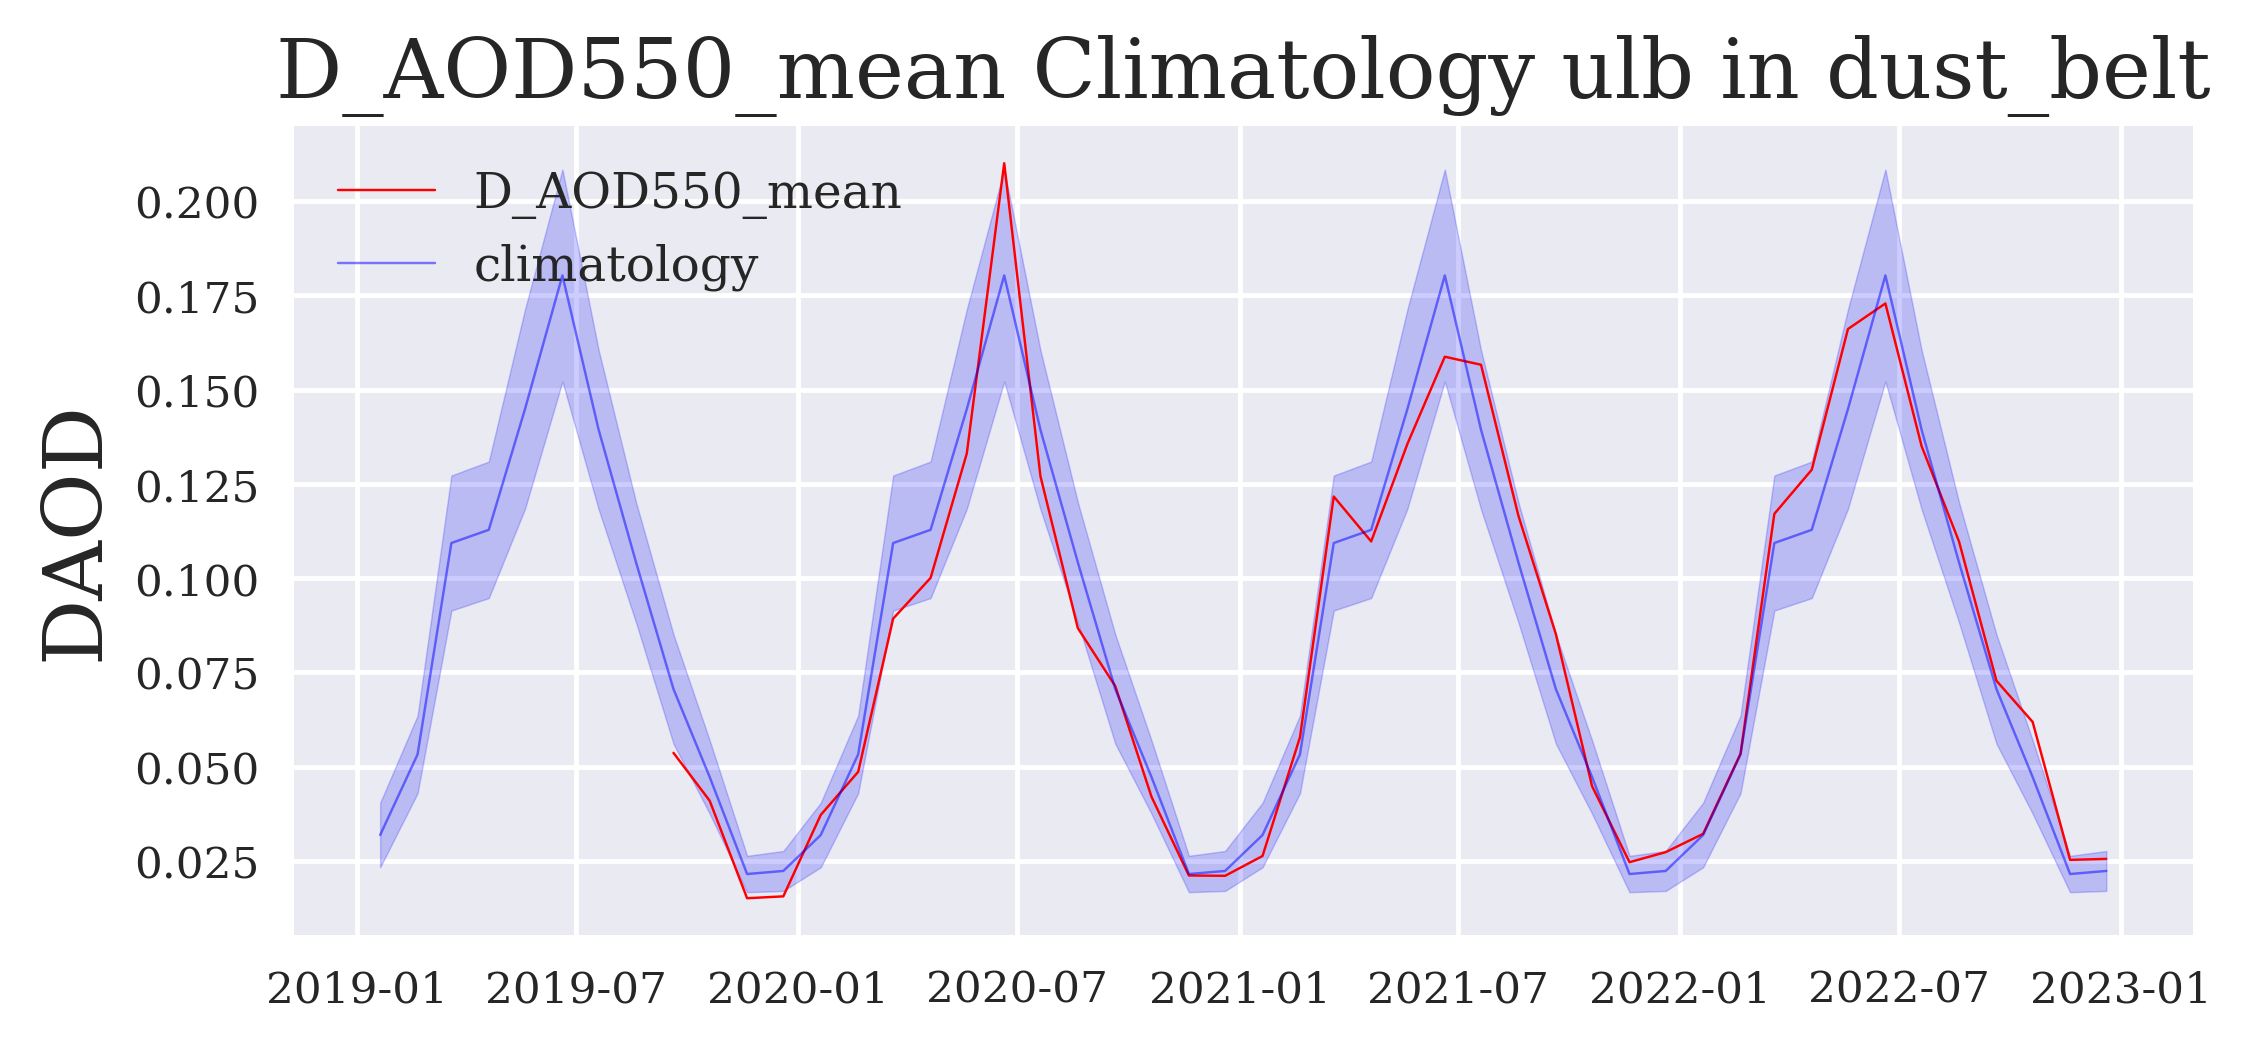

In [ ]:
climatology_ges = []
sdev_p_ges = []
sdev_m_ges = []
time_ges = []
sdev_ges = []
for i in range(len(years)):
    climatology_ges = climatology_ges + climatology
    sdev_p_ges = sdev_p_ges + sdev_p
    sdev_m_ges = sdev_m_ges + sdev_m
    sdev_ges = sdev_ges + sdev
for year in years:
    for month in months:
        t = md.datestr2num(str(year) + '-' + str(month))
        time_ges.append(t)

fig = plt.figure(figsize=(7,3))
plt.plot_date(time, var, '-', label = variable, color = 'red', linewidth = 0.5)    
plt.fill_between(time_ges, sdev_p_ges, sdev_m_ges, color = 'blue', alpha = 0.2)
plt.plot(time_ges, climatology_ges, '-', label = 'climatology', color = 'blue', linewidth = 0.5, alpha = 0.5)

if variable[0:3] == 'AOD': # Total AOD
    plt.ylabel("AOD")
if variable[0:2] == 'DA' or variable[0:2] == 'Da' or variable[0:5] == 'D_AOD': # Dust AOD
    plt.ylabel("DAOD")
if variable[0:2] == 'FM': # Fine Mode AOD
        plt.ylabel("FM_AOD")
if variable[0:1] == 'S': # single scattering albedo
        plt.ylabel("SSA")
if variable[5:9] == 'dust' or variable[2:5] == 'ALT': # Dust Altitude
        plt.ylabel("DALH")
                
plt.legend()
plt.title(variable + ' Climatology ' + algorithm + ' in ' + region)
plt.savefig(PLOTDIR + 'timeseries_with_climatology_' + variable + '_' + algorithm + '_' + region + '.png', dpi=500, bbox_inches='tight')

**FIGURE 5:** The next figure shows the time series in red compared to the multiannual mean in blue and its standard deviation in light blue shading (both repeated from year to year). Exceptional episodes stand out if the red line breaks out of the blue shade.

## Anomaly time series

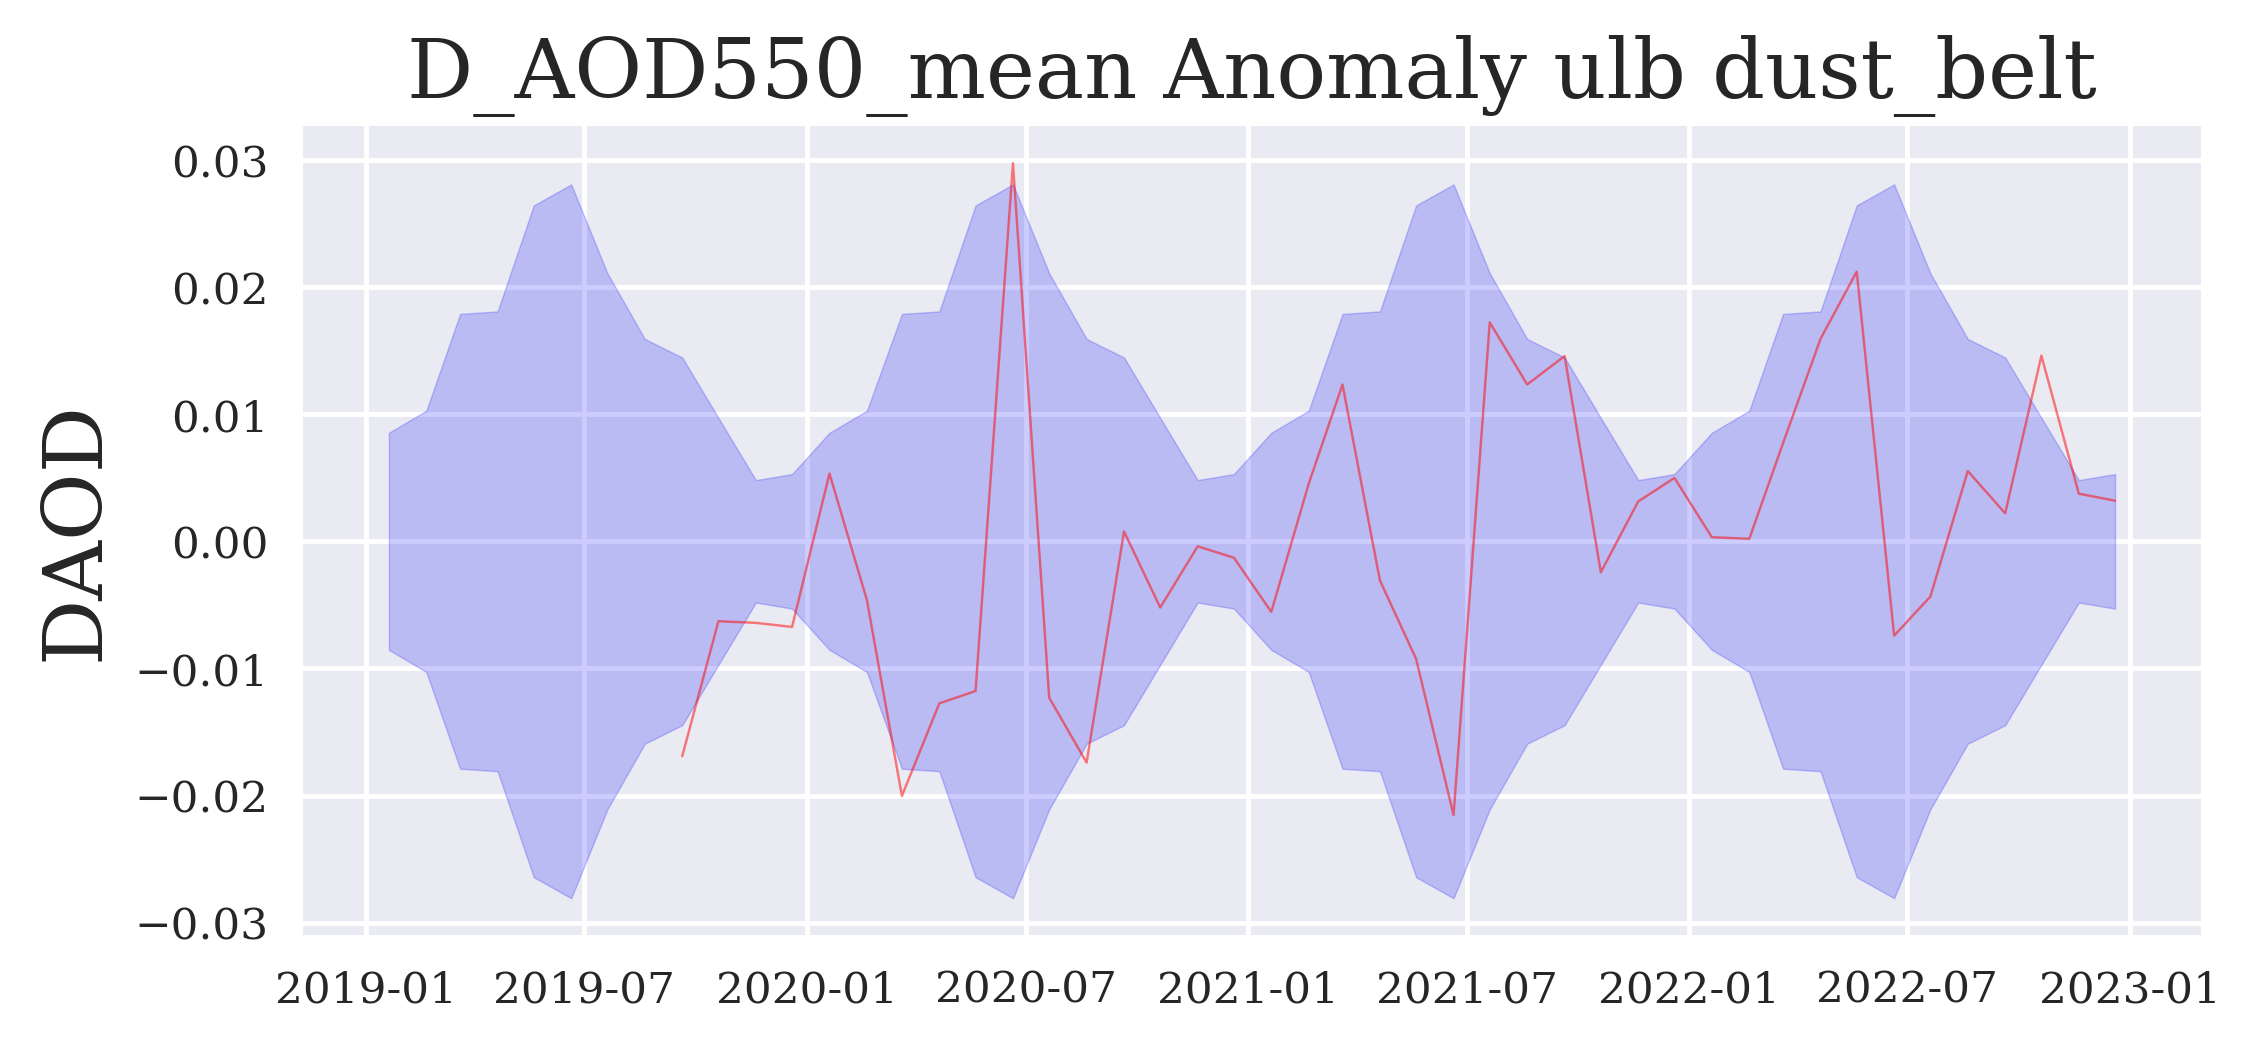

In [ ]:
anomaly = [var[i] - climatology_ges[i] for i in range(len(var))] 

sdev_ges2 = [0.5*sdev_ges[i] for i in range(len(sdev_ges))]

sdev_ges2_ = [ - sdev_ges2[i] for i in range(len(sdev_ges))]

fig = plt.figure(figsize=(7,3))
plt.plot_date(time, anomaly, '-', label = anomaly, color = 'red', linewidth = 0.5, alpha = 0.5)    
plt.fill_between(time_ges, sdev_ges2, sdev_ges2_, color = 'blue', alpha = 0.2)

if variable[0:3] == 'AOD': # Total AOD
    plt.ylabel("AOD")
if variable[0:2] == 'DA' or variable[0:2] == 'Da' or variable[0:5] == 'D_AOD': # Dust AOD
    plt.ylabel("DAOD")
if variable[0:2] == 'FM': # Fine Mode AOD
        plt.ylabel("FM_AOD")
if variable[0:1] == 'S': # single scattering albedo
        plt.ylabel("SSA")
if variable[5:9] == 'dust' or variable[2:5] == 'ALT': # Dust Altitude
        plt.ylabel("DALH")
        
plt.title(variable + ' Anomaly ' + algorithm + ' ' + region)
plt.savefig(PLOTDIR + 'anomaly_timeseries__' + variable + '_' + algorithm + '_' + region + '.png', dpi=500, bbox_inches='tight')

**FIGURE 6:** This final regional time series plot shows the data record in the form of anomalies, i.e. differences between individual monthly data points and the multi-annual monthly mean compared to the multi-annual monthly variations around the zero anomaly line.

This closes our first Jupyter notebook on aerosol properties.

A second Jupyter notebook will create a full Climate Data Record by combining subsequent data record pieces of similar sensors.

## Get more information about Earth Radiation Budget:

- [C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=overview)
- [About the Climate Data Store](https://cds.climate.copernicus.eu/)
- [About the Toolbox documentation](https://cds.climate.copernicus.eu/toolbox/doc/index.html)

## References

[Product User Guide for CDS Aerosol Properties](http://wdc.dlr.de/C3S_312b_Lot2/Documentation/AER/C3S2_312a_Lot2_PUGS_AER_latest.pdf)

[Thomas Popp, Gerrit de Leeuw, Christine Bingen, Christoph Brühl, Virginie Capelle, Alain Chedin, 
Lieven Clarisse, Oleg Dubovik, Roy Grainger, Jan Griesfeller, Andreas Heckel, Stefan Kinne, Lars Klüser, 
Miriam Kosmale, Pekka Kolmonen, Luca Lelli, Pavel Litvinov, Linlu Mei, Peter North, Simon Pinnock, 
Adam Povey, Charles Robert, Michael Schulz, Larisa Sogacheva, Kerstin Stebel, Deborah Stein Zweers, 
Gareth Thomas, Lieuwe Gijsbert Tilstra, Sophie Vandenbussche, Pepijn Veefkind, Marco Vountas and 
Yong Xue, Development, Production and Evaluation of Aerosol Climate Data Records from European 
Satellite Observations (Aerosol_cci), Remote Sensing, 8, 421; doi:10.3390/rs8050421, 2016](https://www.mdpi.com/2072-4292/8/5/421)




[Back to top the Page](#page-top)